In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr  # Import pearsonr function from scipy.stats
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen

#################################################### Data #####################################################
sym_a = 'Bank'
bank_price = pd.read_csv("auto.csv", header=0, parse_dates=True, sep=',', index_col=0)
bank_price = bank_price["Close "]
bank_price.name = sym_a

sym_b = 'Pharma'
pharma_price = pd.read_csv("realty.csv", header=0, parse_dates=True, sep=',', index_col=0)
pharma_price = pharma_price["Close "]
pharma_price.name = sym_b

data = pd.concat([bank_price, pharma_price], axis=1)
#print(data[data.isnull().any(axis=1)])
data.dropna(axis=0, how='any', inplace=True)


/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_537/4175805818.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bank_price = pd.read_csv("auto.csv", header=0, parse_dates=True, sep=',', index_col=0)
/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_537/4175805818.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pharma_price = pd.read_csv("realty.csv", header=0, parse_dates=True, sep=',', index_col=0)


parameters: -325.7694992, 0.0581757


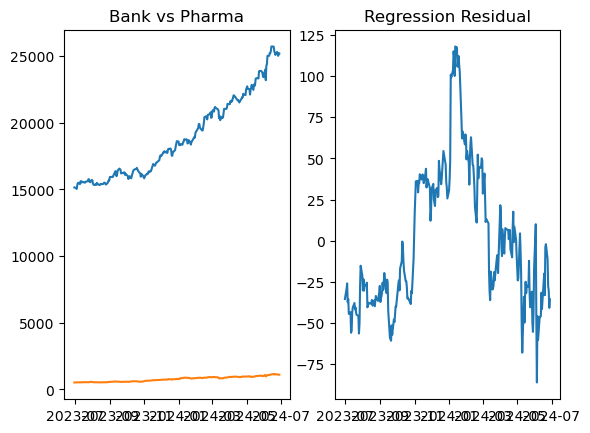

Pearson correlation coefficient: 0.9723970


In [20]:
# The next two lines do the regression
lm_model = LinearRegression(copy_X=True, fit_intercept=True)
lm_model.fit(data[sym_a].values.reshape(-1, 1), data[sym_b].values)  # fit() expects 2D array
print('parameters: %.7f, %.7f' % (lm_model.intercept_, lm_model.coef_[0]))

# present the graph
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_title('Bank vs Pharma')
ax[0].plot(data)
yfit = lm_model.coef_[0] * data[sym_a] + lm_model.intercept_
y_residual = data[sym_b] - yfit
ax[1].set_title('Regression Residual')
ax[1].plot(y_residual)
plt.show()

print('Pearson correlation coefficient: %.7f' % (pearsonr(data[sym_a], data[sym_b])[0]))

In [21]:

####################################### CADF #####################################################
import statsmodels.tsa.stattools as ts
ts.adfuller(y_residual, 1)  # lag = 1
# (-3.667485117146333,
#  0.0045944586170011716,
#  1,
#  4560,
#  {'1%': -3.431784865122899,
#   '5%': -2.8621740417619224,
#   '10%': -2.5671075035106954},
#  625.5003218990623)

lm_model = LinearRegression(copy_X=True, fit_intercept=True)
lm_model.fit(data[sym_b].values.reshape(-1, 1), data[sym_a].values)  # fit() expects 2D array
print('parameters: %.7f, %.7f' % (lm_model.intercept_, lm_model.coef_))
yfit = lm_model.coef_ * data[sym_b] + lm_model.intercept_
y_residual = data[sym_a] - yfit
ts.adfuller(y_residual, 1)  # lag = 1
# statistic = -3.797221868633519

parameters: 6322.4396247, 16.2534425


/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_537/2858920309.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('parameters: %.7f, %.7f' % (lm_model.intercept_, lm_model.coef_))


(-2.0941139161628723,
 0.24688800305344438,
 0,
 247,
 {'1%': -3.457105309726321,
  '5%': -2.873313676101283,
  '10%': -2.5730443824681606},
 3314.918898623733)

In [22]:
####################################### Johansen #####################################################
from statsmodels.tsa.vector_ar.vecm import coint_johansen

jh_results = coint_johansen(data, 0, 1)  # 0 - constant term; 1 - log 1
print(jh_results.lr1)  # dim = (n,) Trace statistic
print(jh_results.cvt)  # dim = (n,3) critical value table (90%, 95%, 99%)
print(jh_results.evec)  # dim = (n, n), columnwise eigen-vectors
v1 = jh_results.evec[:, 0]
v2 = jh_results.evec[:, 1]

# [21.44412674  3.64194243]                 # trace statistic
# [[13.4294 15.4943 19.9349]                # r = 0 critical values
#  [ 2.7055  3.8415  6.6349]]               # r <= 1 critical values
# [[ 0.53474958  0.02398649]                # eigenvectors
#  [-0.45169106  0.12036402]]

[6.60054286 0.51132856]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[[ 0.00112182 -0.00085858]
 [-0.02154286  0.00954148]]
